<a href="https://colab.research.google.com/github/kaifoerster/ML_Lab_1_Group-A/blob/main/Lab_Session_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">
  <h1>Architecture design in neural networks</h2>
</div>





### Loading the data



In [15]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
# from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from IPython.display import display, clear_output
import time
import tensorflow as tf
import tensorflow.keras as keras



GLOBAL_RANDOM_STATE = 21
tf.random.set_seed(GLOBAL_RANDOM_STATE)
np.random.seed(GLOBAL_RANDOM_STATE)


In [16]:
X_train = np.random.random((10**4, 10))
X_train = tf.convert_to_tensor(X_train)

Y_train = np.random.random((10**4,))
Y_train = tf.convert_to_tensor(Y_train)

### Constructing the model


In [17]:
class LazySequential(keras.models.Sequential):

  def __init__(self, hidden_layers=10, activation_fn=tf.nn.relu):

    super().__init__()

    for i in range(hidden_layers):
      self.add(keras.layers.Dense(2**3,
                                  use_bias=False,
                                  activation=activation_fn))

    self.add(keras.layers.Dense(1))


### Online learning, minibatch and batch


In [18]:
model = LazySequential(10)
model.compile(optimizer="sgd", loss=keras.losses.MeanSquaredError(), metrics=["acc", "mae"])

In [19]:
start_online = time.time()
history_online = model.fit(X_train, Y_train, epochs=50, verbose=0)
end_online = time.time()

In [20]:
start_full_batch = time.time()
history_full_batch = model.fit(X_train, Y_train, batch_size=X_train.shape[0], epochs=50, verbose=0)
end_full_batch = time.time()

In [21]:
start_mini_batch = time.time()
history_mini_batch = model.fit(X_train, Y_train, batch_size=2**5, epochs=50, verbose=False)
end_mini_batch = time.time()

In [22]:
#TODO: plot loss over time and print computational time of the three variations.

Total training time for full_batch over 50 epochs: 0.5 seconds.
Total training time for mini_batch over 50 epochs: 21.0 seconds.
Total training time for online over 50 epochs: 21.4 seconds.


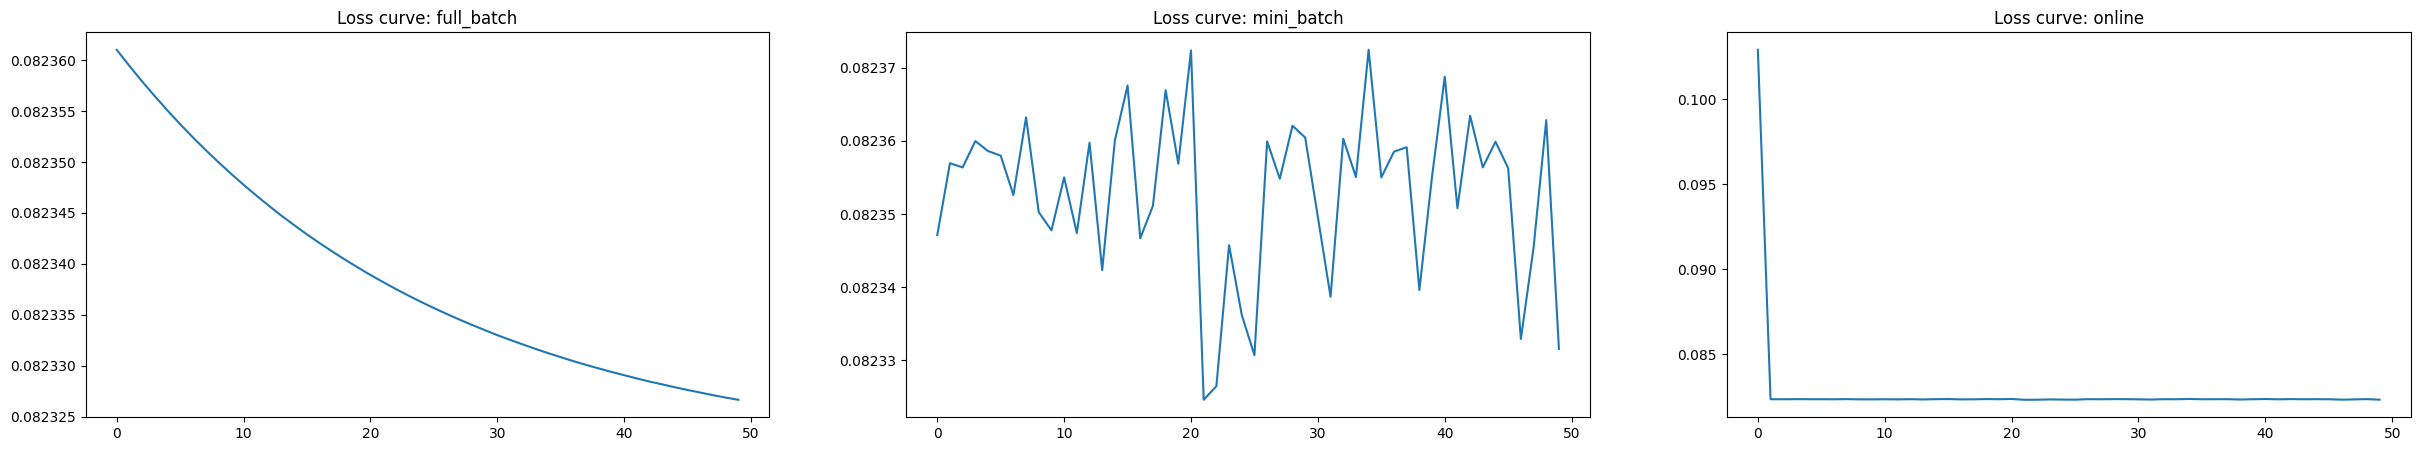

In [23]:
# @title
fig, ax = plt.subplots(1, 3, figsize=(30, 5))

batch_size = ["full_batch", "mini_batch", "online"]

for i in range(3):
  size = batch_size[i]
  start = globals()[f"start_{size}"]
  end = globals()[f"end_{size}"]
  history = globals()[f"history_{size}"].history

  print(f"Total training time for {size} over 50 epochs: {(end - start):.1f} seconds.")

  ax[i].plot(history['loss'])
  ax[i].set_title(f"Loss curve: {size}")


### Vanishing gradient

In [24]:
def get_gradient_updates(model, x, y):
  with tf.GradientTape() as tape:
    predictions = model(x)
    loss = model.compute_loss(y=y, y_pred=predictions)

  gradient_updates = tape.gradient(loss, model.trainable_variables)
  return gradient_updates

In [25]:
big_model = LazySequential(50, activation_fn=tf.nn.tanh)
big_model.compile(optimizer="sgd", loss=keras.losses.MeanSquaredError())

In [26]:
#TODO: compute the sum of the absolute weights for hidden layers 1 to 25 and for hidden layers 25 to 50 (remember to avoid first and output layer).

In [29]:
# @title
sum1 = sum([ tf.math.reduce_sum( tf.abs(grad_updates[i]) ).numpy() for i in range(1,26) ])
sum2 = sum([ tf.math.reduce_sum( tf.abs(grad_updates[i]) ).numpy() for i in range(26, 51) ])

print(f"Absolute sum of weights for the first half of the hidden layers: {sum1: .1f}")
print(f"Absolute sum of weights for the second half of the hidden layers: {sum2: .1f}")

Absolute sum of weights for the first half of the hidden layers:  9.0
Absolute sum of weights for the second half of the hidden layers:  6.3


In [ ]:
#TODO: plot heatmaps of the gradient updates for the gradient: do you recognize a pattern?

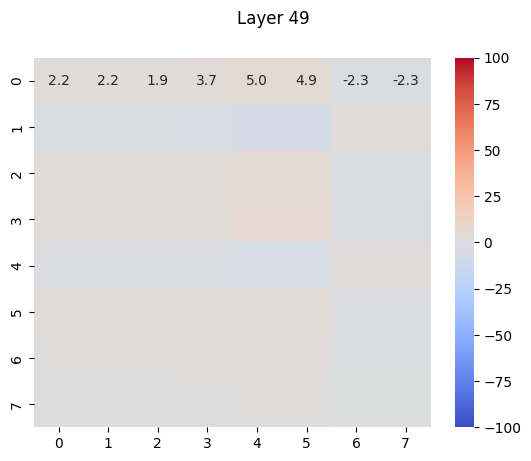

In [28]:
# @title
grad_updates = get_gradient_updates(big_model, X_train, Y_train)

for i in range(len(grad_updates)):
  grad_update = grad_updates[i]
  try:
    if len(grad_update.shape) == 2 and grad_update.shape[1] != 1:
      heatmap = sns.heatmap(grad_update * 10**3, vmin=-100, vmax=100,
                            annot=True, cmap='coolwarm', fmt='.1f')

      plt.suptitle(f"Layer {i}")
      plt.show()
      time.sleep(1)
      clear_output(wait=True)
  except:
    continue

### Hyperparameter Tuning



In [ ]:
!pip install keras_tuner

In [30]:
import keras_tuner

Using TensorFlow backend


In [31]:
def model_builder(hp):

  model = keras.Sequential()

  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  mse = keras.losses.MeanSquaredError()
  model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
                loss=mse,
                metrics=[mse])

  return model

In [32]:
tuner = keras_tuner.RandomSearch(model_builder, objective="val_loss", max_trials=10, seed=GLOBAL_RANDOM_STATE, overwrite=True)

In [33]:
tuner.search(X_train, Y_train, epochs=10, validation_split=0.2) 

Trial 10 Complete [00h 00m 05s]
val_loss: 0.08794473111629486

Best val_loss So Far: 0.08290233463048935
Total elapsed time: 00h 00m 54s


In [34]:
best_hp = tuner.get_best_hyperparameters()[0]

In [ ]:
#TODO: build an HyperModel constructor that implements a Neural Network with 4 layers in a funnel-fashioned way:
# the first layer will have no. of units of the best model from step 1. The output size
# of the other layers will be a tunable hyperparameter of a smaller size than the output size of the previous layer.
# use learning rate from the best model and fine-tune with RandomSearch on our random dataset

In [42]:
# @title
def funnel_model_builder(hp, best_hp):

  model = keras.models.Sequential()
  model.add(keras.layers.Dense(best_hp["units"]))

  for i in range(3):
      last_layer_shape = model.layers[-1].units
      model.add(keras.layers.Dense(units=hp.Int(f"unit_{i+1}_layer", 1, last_layer_shape)))

  model.add(keras.layers.Dense(1))
  model.compile(loss=keras.losses.MeanSquaredError(), optimizer="sgd")
  mse = keras.losses.MeanSquaredError()
  model.compile(optimizer=keras.optimizers.SGD(learning_rate=best_hp["learning_rate"]),
                loss=mse,
                metrics=[mse])
  return model

In [43]:
# @title
tuner_depth = keras_tuner.RandomSearch(lambda hp: funnel_model_builder(hp, best_hp),
                                       objective="val_loss",
                                       max_trials=10,
                                       seed=GLOBAL_RANDOM_STATE,
                                       overwrite=True)

In [44]:
# @title
tuner_depth.search(X_train, Y_train, epochs=10, validation_split=0.2)

Trial 10 Complete [00h 00m 07s]
val_loss: 0.08323270082473755

Best val_loss So Far: 0.08311885595321655
Total elapsed time: 00h 01m 07s


In [55]:
funnel_hp = tuner_depth.get_best_hyperparameters(num_trials=1)[0]

In [58]:
funnel_hp['unit_3_layer']

1